In [43]:
# Classifying a Suspected Thief Zone Using K-Nearest Neighbors (KNN) – A Supervised Learning Approach

In [44]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, cross_val_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [45]:
# 1: Data Extraction, Processing & Analysis

In [46]:
# Load Excel file into a dataframe
file_path = "petrophysical data.xlsx"
xls = pd.ExcelFile(file_path)
df = xls.parse('petrophysical_data')

# Data cleaning
df_clean = df.iloc[2:].copy()
df_clean.columns = df.iloc[1].values
df_clean.dropna(how='all', inplace=True)
df_clean.dropna(axis=1, how='all', inplace=True)

# Replace "-" in rows with NaN and convert to numeric values
for col in df_clean.columns[1:]:
    df_clean[col] = pd.to_numeric(df_clean[col].replace("-", np.nan), errors='coerce')

# Drop rows missing key petrophysical parameters
df_clean.dropna(subset=["Top\n[m MD RKB]", "Base\n[m MD RKB]", "PHIF\n[fraction]",  "SW\n[fraction]", "KLOGH\narithmetic [mD]"], inplace=True)
df_clean = df_clean.reset_index(drop=True)

# Rename columns
df_clean.rename(columns={
    "Formation / Zone": "Zone",
    "Top\n[m MD RKB]": "Top",
    "Base\n[m MD RKB]": "Base",
    "N/G\n[fraction]": "NG",
    "PHIF\n[fraction]": "PHIF",
    "SW\n[fraction]": "SW",
    "KLOGH\narithmetic [mD]": "KLOGH_arithmetic",
    "KLOGH\nharmonic [mD]": "KLOGH_harmonic",
    "KLOGH\ngeometric [mD]": "KLOGH_geometric"
}, inplace=True)

# Add calculated feature: Thickness of Zone (Base Depth minus Top Depth)
df_clean["Thickness"] = df_clean["Base"] - df_clean["Top"]

In [47]:
# Preview Dataframe
print('Dataframe Info:\n')
print(df_clean.info())

# View the fully processed Dataframe
print('\nFull Dataframe:\n')   
df_clean

Dataframe Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Zone              9 non-null      object 
 1   Top               9 non-null      float64
 2   Base              9 non-null      float64
 3   NG                9 non-null      float64
 4   PHIF              9 non-null      float64
 5   SW                9 non-null      float64
 6   KLOGH_arithmetic  9 non-null      float64
 7   KLOGH_harmonic    9 non-null      float64
 8   KLOGH_geometric   9 non-null      float64
 9   Thickness         9 non-null      float64
dtypes: float64(9), object(1)
memory usage: 852.0+ bytes
None

Full Dataframe:



,Zone,Top,Base,NG,PHIF,SW,KLOGH_arithmetic,KLOGH_harmonic,KLOGH_geometric,Thickness
0,Devonian,3435.0,3500.2,0.692,0.168,0.899,263.0,0.5,10.0,65.2
1,Upper Devonian,3435.0,3454.7,0.822,0.170,0.819,65.0,0.5,15.0,19.7
2,Lower Devonian,3463.8,3500.2,0.565,0.156,0.946,4.0,0.4,1.5,36.4
3,Devonian 3.3 (12),3435.0,3441.5,0.723,0.173,0.829,108.0,32.0,74.0,6.5
4,Devonian 3.2 (11),3441.5,3448.0,0.923,0.178,0.760,66.0,3.0,26.0,6.5
5,Devonian 3.1 (10),3448.0,3454.7,0.821,0.158,0.882,28.0,0.2,2.0,6.7
6,Rotleigend,3500.2,3543.7,0.133,0.123,0.850,3.0,1.0,2.0,43.5
7,Crystalline basement,3543.7,3608.0,0.723,0.135,0.975,0.7,0.3,0.4,64.3
8,Top basement,3608.0,3682.0,0.051,0.119,0.973,0.3,0.2,0.2,74.0


In [48]:
# 2: Visualize Distributions of Key Features in Dataset

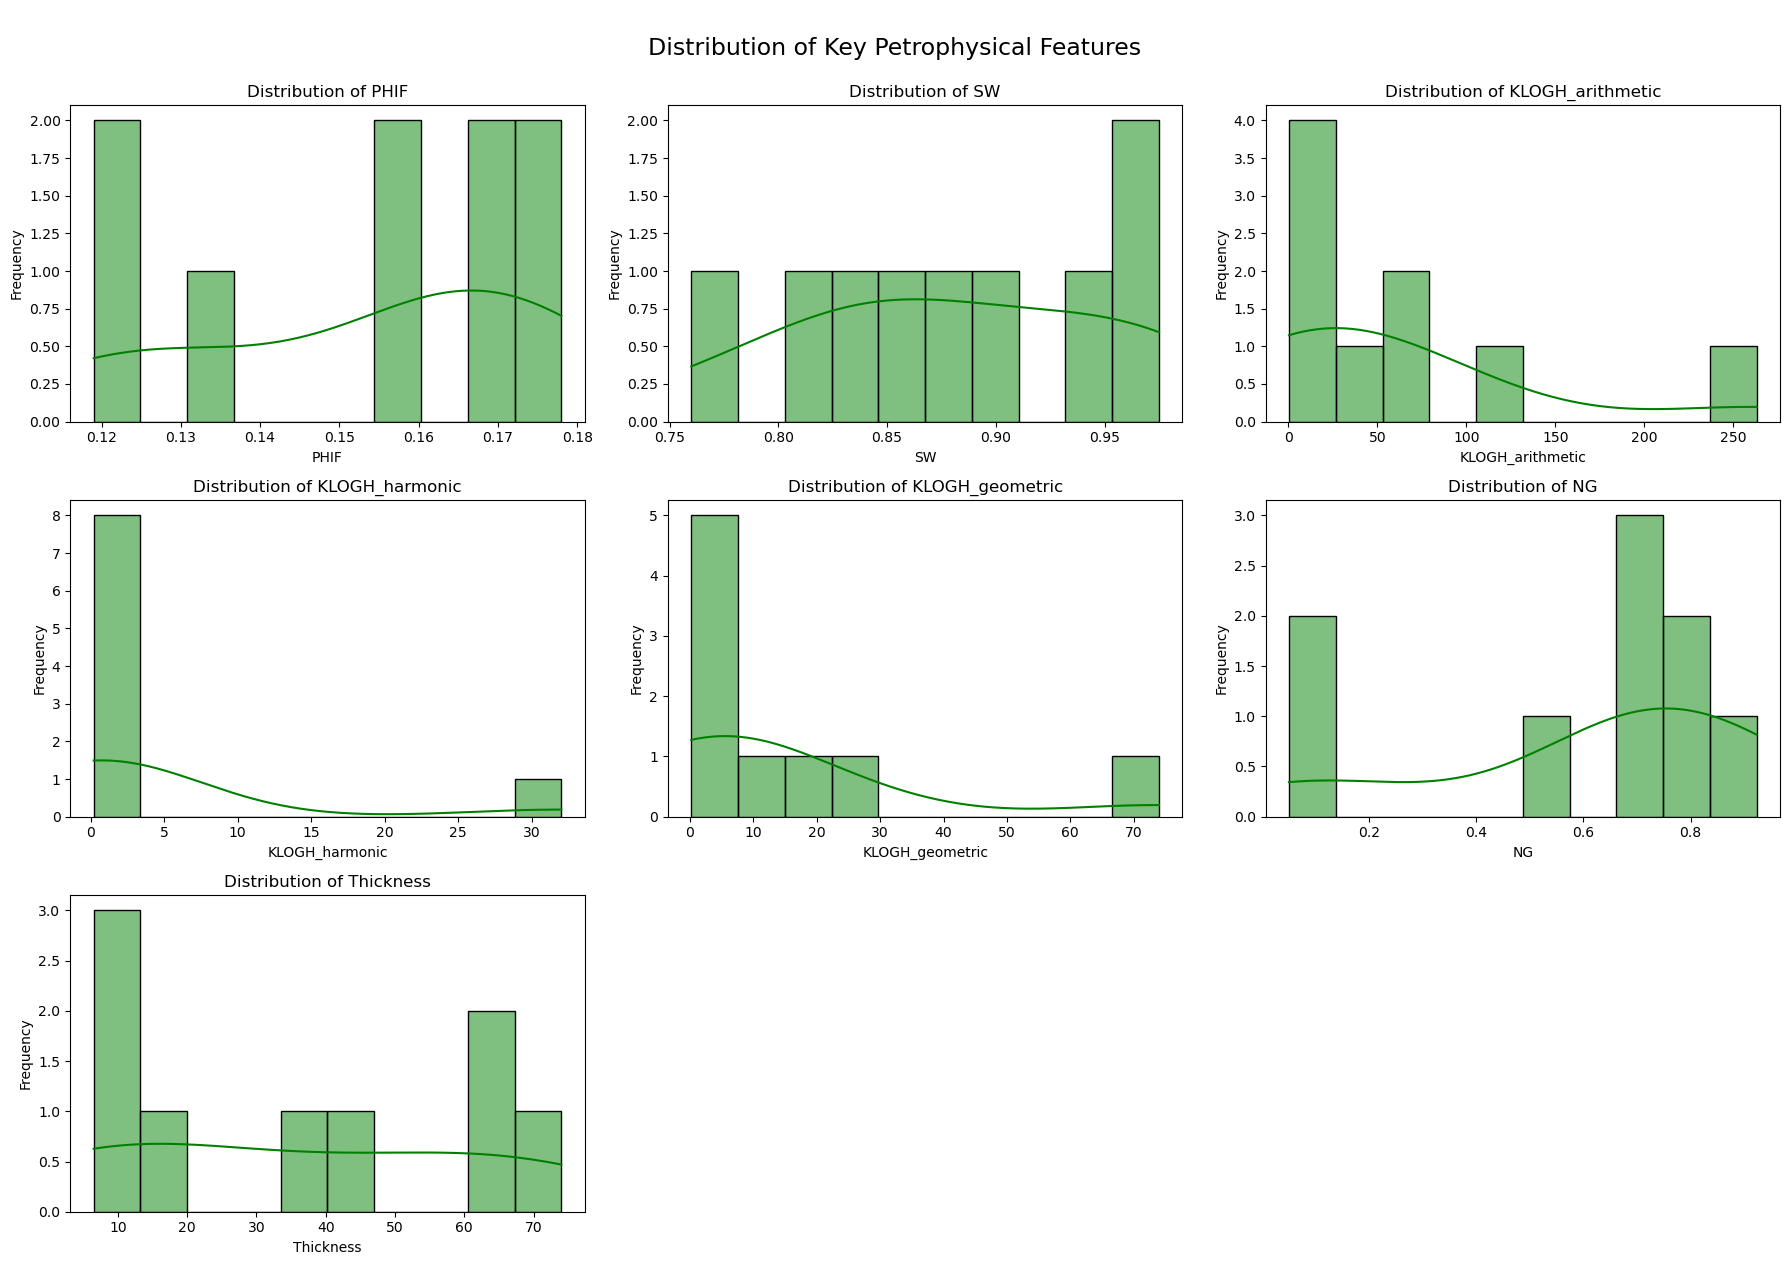

In [49]:
# Define Key features to visualize
features_to_plot = ["PHIF", "SW", "KLOGH_arithmetic", "KLOGH_harmonic", "KLOGH_geometric", "NG", "Thickness"]

# Plot histograms
plt.figure(figsize=(18, 12))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_clean[feature], kde=True, bins=10, color="green")
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.tight_layout()

plt.suptitle("\nDistribution of Key Petrophysical Features", fontsize=17, y=1.05)
plt.savefig('histogram_stats.png', dpi=300)
plt.show()

In [50]:
# 3: Generate Descriptive Statistics for Feature Selection and Setting Thresholds

In [51]:
"""
This step analyzes the distribution of key petrophysical features to support 
feature selection and threshold determination for thief zone classification.
Selected features include porosity, permeability (arithmetic, harmonic, geometric),
water saturation, net-to-gross ratio, and thickness. These parameters are critical
for understanding flow characteristics and reservoir quality.

The statistical summary (mean, percentiles, standard deviation, etc.) provides 
insights into natural data cutoffs that guide the labeling criteria used for training 
the KNN classifier.
"""

# Select key features
stats_features = ["PHIF", "SW", "KLOGH_arithmetic", "KLOGH_harmonic", "KLOGH_geometric", "NG", "Thickness"]

# Compute descriptive statistics including percentiles
summary_stats = df_clean[stats_features].describe(percentiles=[.25, .5, .75, .9]).T

# Rename columns for clarity
summary_stats = summary_stats.rename(columns={
    "25%": "25th_percentile",
    "50%": "Median (50th)",
    "75%": "75th_percentile",
    "90%": "90th_percentile",
    "std": "Standard Deviation",
    "mean": "Mean",
    "min": "Minimum",
    "max": "Maximum"
})

# Display statistics table
print(f"Descriptive Statistics for Key Petrophysical Features")
summary_stats

Descriptive Statistics for Key Petrophysical Features


,count,Mean,Standard Deviation,Minimum,25th_percentile,Median (50th),75th_percentile,90th_percentile,Maximum
PHIF,9.0,0.153333,0.022226,0.119,0.135,0.158,0.170,0.1740,0.178
SW,9.0,0.881444,0.074160,0.760,0.829,0.882,0.946,0.9734,0.975
KLOGH_arithmetic,9.0,59.777778,85.193262,0.300,3.000,28.000,66.000,139.0000,263.000
KLOGH_harmonic,9.0,4.233333,10.449522,0.200,0.300,0.500,1.000,8.8000,32.000
KLOGH_geometric,9.0,14.566667,23.921120,0.200,1.500,2.000,15.000,35.6000,74.000
NG,9.0,0.605889,0.308541,0.051,0.565,0.723,0.821,0.8422,0.923
Thickness,9.0,35.866667,27.428225,6.500,6.700,36.400,64.300,66.9600,74.000


In [52]:
# 4: Generate Correlation Matrix to validate Threshold Selection for Thief Zone Labelling

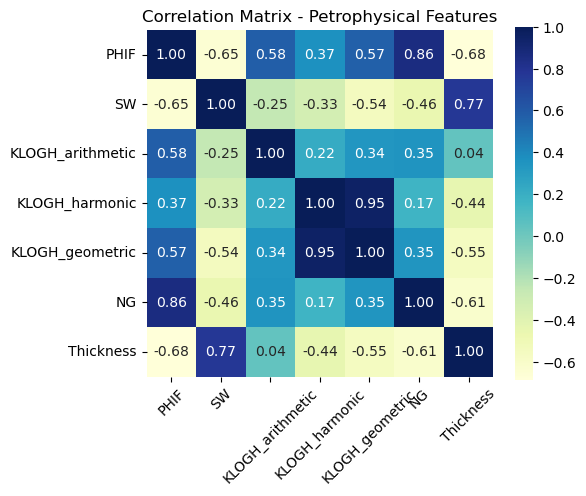

In [53]:
"""
This step investigates the relationships between key petrophysical features using a Pearson 
correlation matrix. This is useful because if some features are too similar, we may not 
need to include all of them in our thief zone labelling.

Features analyzed include porosity, permeability (various forms), water saturation, 
net-to-gross ratio, and thickness. This helps us decide which features are important to retain and which 
ones may be left out to avoid redundancy.
"""

# Select features relevant for correlation analysis
correlation_features = [
    "PHIF", "SW", "KLOGH_arithmetic", "KLOGH_harmonic",
    "KLOGH_geometric", "NG", "Thickness"
]

# Drop rows with NaN values in correlation features
df_corr = df_clean[correlation_features].dropna()

# Compute correlation matrix
correlation_matrix = df_corr.corr()
# print(correlation_matrix)

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f", square=True)
plt.title("Correlation Matrix - Petrophysical Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

In [54]:
# 5: Apply New Thief Zone Labeling Logic

In [55]:
"""
This step defines the thief zone classification labels based on reservoir engineering insight
and prior data analysis. Zones are labeled as 'Thief Zones' if they exhibit:

- High permeability (KLOGH_arithmetic > 139 mD), indicating strong flow potential
- Low net-to-gross ratio (NG < 0.75), suggesting poor reservoir quality

These thresholds were derived from data distribution (e.g., histogram gaps, percentiles)
and align with domain knowledge of thief zone characteristics. A binary 'thief_zone' label (1 or 0)
is assigned to each zone for use in supervised learning.
"""

# Set label thresholds based on statiscal data
perm_threshold = 66.0
ntg_threshold = 0.75

# Create binary thief_zone label: high perm + low NG
df_clean["Thief Zone"] = (
    (df_clean["KLOGH_arithmetic"] > perm_threshold) &
    (df_clean["NG"] < ntg_threshold)
).astype(int)


# Display thief zone and non-thief zone counts in a Dataframe
thief_label_counts = (
    df_clean["Thief Zone"]
    .value_counts()
    .rename(index={0: "Non-Thief Zone", 1: "Thief Zone"})
    .reset_index()
    .rename(columns={"count": "Count", "Thief Zone": "Zone Class"})
)

# Display Dataframe
display((df_clean[["Zone", "NG", "KLOGH_arithmetic", "Thief Zone"]]))

# Display table for thief zone counts
print(thief_label_counts)

,Zone,NG,KLOGH_arithmetic,Thief Zone
0,Devonian,0.692,263.0,1
1,Upper Devonian,0.822,65.0,0
2,Lower Devonian,0.565,4.0,0
3,Devonian 3.3 (12),0.723,108.0,1
4,Devonian 3.2 (11),0.923,66.0,0
5,Devonian 3.1 (10),0.821,28.0,0
6,Rotleigend,0.133,3.0,0
7,Crystalline basement,0.723,0.7,0
8,Top basement,0.051,0.3,0


       Zone Class  Count
0  Non-Thief Zone      7
1      Thief Zone      2


In [56]:
# 6: KNN Classification Workflow - Feature Preparation, Scaling, and Cross-validation

In [57]:
"""
This step prepares the data for the K-Nearest Neighbors (KNN) classification model.
Key actions:
    - Selects final input features (excluding PHIF due to strong correlation with NG)
    - Standardizes the feature set for equal weighting in distance calculation
    - Uses Leave-One-Out Cross-Validation (LOOCV) to find the optimal value of k for the KNN classifier, 
      based on accuracy scores.
      
How LOOCV works:
    - LOOCV is used due to the small dataset size, ensuring each sample is tested once while the rest are used for training.
    - Uses 1 sample for testing, the rest for training. Repeats this process once per sample.
    - The value of k that yields the highest average accuracy is selected as the best model configuration.
"""

# Select relevant features based on final criteria (no PHIF)
feature_cols = ["Top", "Base", "SW", "KLOGH_arithmetic", "KLOGH_harmonic", "KLOGH_geometric", "NG", "Thickness"]

# Prepare input features (X) and target labels (y)
X = df_clean[feature_cols].dropna()
y = df_clean.loc[X.index, "Thief Zone"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Leave-One-Out Cross-validation to evaluate accuracy for each k
loo = LeaveOneOut()
cv_scores = {}

for k in range(1, len(X_scaled), 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=loo, scoring='accuracy')
    cv_scores[k] = scores.mean()

# Store cross-validation results in a DataFrame
cv_results_df = pd.DataFrame({
    "k": list(cv_scores.keys()),
    "mean_accuracy": list(cv_scores.values())
}).sort_values(by="mean_accuracy", ascending=False).reset_index(drop=True)

# Display the accuracy results
print("Leave-One-Out Cross-Validation Accuracy for Different k Values:")
print(cv_results_df)

# Final k selection
selected_k = 3
print(f"\nWe selected k = {selected_k} for modeling because it gives good accuracy and helps avoid noise (like with k=1) while still being small enough to reflect local data patterns.")

Leave-One-Out Cross-Validation Accuracy for Different k Values:
   k  mean_accuracy
0  1       0.777778
1  3       0.777778
2  5       0.777778
3  7       0.777778

We selected k = 3 for modeling because it gives good accuracy and helps avoid noise (like with k=1) while still being small enough to reflect local data patterns.


In [58]:
# 7: KNN Cross-Validation Using Stratified K-Fold to Justify LOOCV

In [59]:
"""
We validated the Leave-One-Out Cross-Validation (LOOCV) results using Stratified K-Fold Cross-Validation.

How Stratified K-Fold works:
    - Splits the dataset into k equal folds.
    - Maintains the same class ratio (e.g., thief vs non-thief) in each fold.
    - Trains on k-1 folds and tests on 1, repeating the process k times.

This method is especially useful given our dataset's class imbalance (only 2 thief zones out of 9).
Validating with it confirms that LOOCV results are consistent and helps ensure class imbalance isn’t skewing our results.
"""

# Feature selection
feature_cols = ["Top", "Base", "SW", "KLOGH_arithmetic", "KLOGH_harmonic", "KLOGH_geometric", "NG", "Thickness"]
X = df_clean[feature_cols].dropna()
y = df_clean.loc[X.index, "Thief Zone"]

# Feature scaling - to ensure all features contribute equally to distance calculations
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified K-Fold setup (3 folds due to small dataset)
strat_kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
strat_cv_scores = {}

# Evaluate accuracy across different values of k
max_k = min(5, len(X_scaled) - len(X_scaled) // 3)   #  ensures k never exceeds the number of training samples per fold
for k in range(1, max_k):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=strat_kfold, scoring='accuracy')
    strat_cv_scores[k] = scores.mean()

# Store and view results
strat_cv_df = pd.DataFrame({
    "k": list(strat_cv_scores.keys()),
    "mean_accuracy": list(strat_cv_scores.values())
}).sort_values(by="mean_accuracy", ascending=False).reset_index(drop=True)

print("Stratified K-Fold Cross-Validation Accuracy for Different k Values:")
print(strat_cv_df)

Stratified K-Fold Cross-Validation Accuracy for Different k Values:
   k  mean_accuracy
0  1          0.775
1  2          0.775
2  3          0.775
3  4          0.775


In [60]:
# 8: Train Final KNN Model with k = 3 and Predict Test Zone

In [61]:
# Define the test zone as provided in the assignment
test_point = pd.DataFrame([{
    "Top": 3455,
    "Base": 3464,
    "SW": 0.939,
    "KLOGH_arithmetic": 1280,
    "KLOGH_harmonic": 48,
    "KLOGH_geometric": 358,
    "NG": 0.923,
    "Thickness": 9
}])

# Standardize the test point using the same scaler 
test_point_scaled = scaler.transform(test_point)

# Train final model
final_knn = KNeighborsClassifier(n_neighbors=3)
final_knn.fit(X_scaled, y)

# Predict thief zone status
prediction = final_knn.predict(test_point_scaled)
prediction_label = "Thief Zone" if prediction[0] == 1 else "Non-Thief Zone"
print(f"Test point is classified as: {prediction_label}")

Test point is classified as: Thief Zone


In [62]:
# 9. Visualizatin of KNN Classification Results

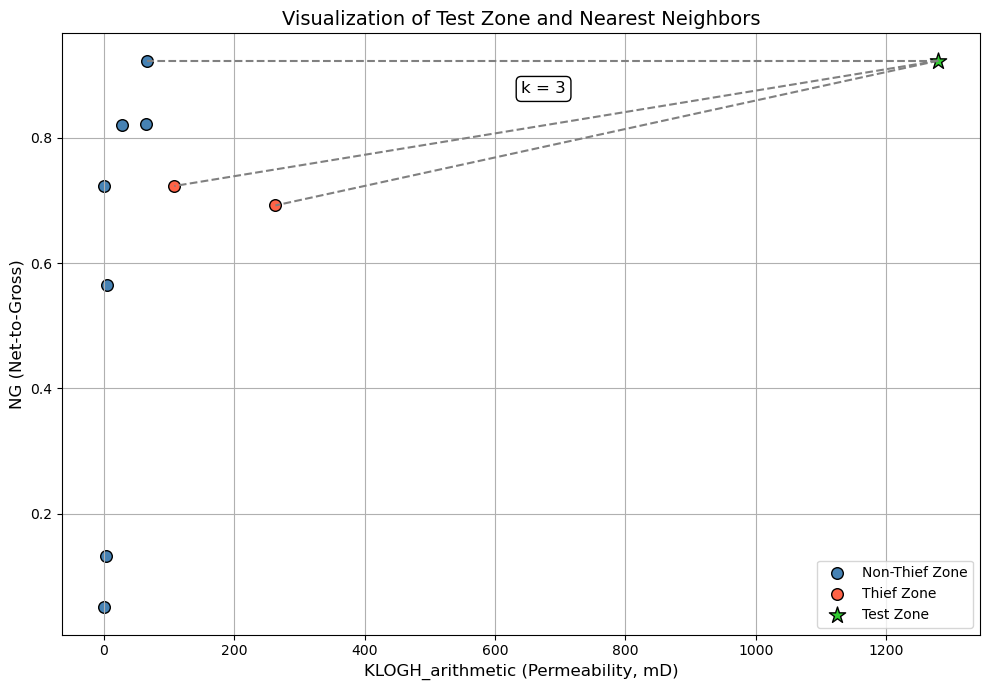

In [63]:
# Select 2 features for plotting
plot_features = ["KLOGH_arithmetic", "NG"]
X_plot = df_clean[plot_features].dropna()
y_plot = df_clean.loc[X_plot.index, "Thief Zone"]

# Fit KNN with k=3 for finding neighbors
knn_plot = KNeighborsClassifier(n_neighbors=3)
knn_plot.fit(X_plot, y_plot)

# Define the test point
test_point_plot = pd.DataFrame([{
    "KLOGH_arithmetic": 1280,
    "NG": 0.923
}])

# Get indices of 3 nearest neighbors
_, indices = knn_plot.kneighbors(test_point_plot)

# Create the plot
plt.figure(figsize=(10, 7))

# Plot training data
for label, color in zip([0, 1], ["steelblue", "tomato"]):
    subset = X_plot[y_plot == label]
    plt.scatter(subset["KLOGH_arithmetic"], subset["NG"],
                label="Non-Thief Zone" if label == 0 else "Thief Zone",
                color=color, s=70, edgecolor='k')

# Plot test point
plt.scatter(test_point_plot["KLOGH_arithmetic"], test_point_plot["NG"],
            label="Test Zone", color="limegreen", s=150, marker='*', edgecolor='black')

# Draw lines from neighbors to test point
for idx in indices[0]:
    neighbor = X_plot.iloc[idx]
    plt.plot([test_point_plot["KLOGH_arithmetic"].values[0], neighbor["KLOGH_arithmetic"]],
             [test_point_plot["NG"].values[0], neighbor["NG"]],

             linestyle='dashed', color='gray')

# Format Plot Labels and Text
plt.text(
    0.5, 0.9,
    "k = 3",
    transform=plt.gca().transAxes,
    fontsize=12,
    color='black',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)
plt.xlabel("KLOGH_arithmetic (Permeability, mD)", fontsize=12)
plt.ylabel("NG (Net-to-Gross)", fontsize=12)
plt.title("Visualization of Test Zone and Nearest Neighbors", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('visualization-knn.png')
plt.show()